In [112]:
import os
import torch
import tensorflow as tf
from torchvision import transforms
from torchvision.models import resnet101
from PIL import Image
import numpy as np
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Lambda, Concatenate
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [8]:
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove.twitter.27B.zip -d glove_twitter/


--2025-01-21 11:26:41--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2025-01-21 11:26:41--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2025-01-21 11:26:42--  https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [ap

In [137]:
def load_vocab(vocab_file):
    vocab = {}
    with open(vocab_file, 'r', encoding='utf-8') as f:
        for idx, line in enumerate(f):
            word = line.strip() 
            vocab[word] = idx
    return vocab

def load_glove_embeddings(glove_file, vocab, embedding_dim=200):
    embedding_matrix = np.zeros((len(vocab), embedding_dim))

    print("Loading GloVe embeddings...")
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            if word in vocab:
                idx = vocab[word]
                embedding_matrix[idx] = vector
    print("Loaded GloVe embeddings!")
    return embedding_matrix

vocab_file_path = "/kaggle/input/vector-vocab/vocab.txt" 
glove_file_path = "/kaggle/working/glove_twitter/glove.twitter.27B.200d.txt" 

vocab = load_vocab(vocab_file_path)
embedding_matrix = load_glove_embeddings(glove_file_path, vocab)

print(f"Loaded vocabulary with {len(vocab)} words.")


Loading GloVe embeddings...
Loaded GloVe embeddings!
Loaded vocabulary with 36842 words.


In [138]:
import torch.nn as nn
import torchvision.models as models
import json

class AttributePredictor(nn.Module):
    def __init__(self, num_classes):
        super(AttributePredictor, self).__init__()
        self.resnet = models.resnet101(pretrained=False) 
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        logits = self.resnet(x)
        probs = self.sigmoid(logits)
        return probs

with open("/kaggle/input/attribute-prediction/vocab (1).json", "r") as f:
    vocab = json.load(f)

vocab_list = vocab
num_classes = len(vocab_list)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AttributePredictor(num_classes=num_classes)

state_dict = torch.load("/kaggle/input/attribute-prediction/attribute_predictor_multi_gpu.pth", map_location=device)

if any(key.startswith("module.") for key in state_dict.keys()):
    state_dict = {key.replace("module.", ""): value for key, value in state_dict.items()}

model.load_state_dict(state_dict, strict=False) 
model.to(device)
model.eval()


<ipython-input-138-7c0d1a576789>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/kaggle/input/attribute-prediction/attribute_predictor_multi_gpu.

AttributePredictor(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(


In [140]:
# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [141]:
vocab = load_vocab(vocab_file_path)

In [142]:
class AttributeGuidance:
    def __init__(self, embedding_matrix, embedding_dim):
        self.embedding_matrix = embedding_matrix
        self.embedding_dim = embedding_dim

    def build_model(self):
        attributes_input = tf.keras.Input(shape=(5,), dtype=tf.int32, name="attributes_input")
        
        # Embedding layer for the attributes input
        embedding_layer = layers.Embedding(input_dim=self.embedding_matrix.shape[0],
                                           output_dim=self.embedding_dim,
                                           weights=[self.embedding_matrix],
                                           trainable=False)(attributes_input)
        
        # Process the attributes (this can be a simple dense layer)
        attributes_output = layers.Dense(128, activation='relu')(embedding_layer)
        
        # Output the processed attribute guidance vector
        return tf.keras.Model(inputs=[attributes_input], outputs=attributes_output)


In [143]:
import tensorflow as tf
from tensorflow.keras import layers, Model

class TextFeature:
    def __init__(self, vocab_size, embedding_dim, seq_len, hidden_size, dropout_rate, embedding_matrix):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.seq_len = seq_len
        self.hidden_size = hidden_size
        self.dropout_rate = dropout_rate
        self.embedding_matrix = embedding_matrix

    def model_create(self):
        text_input = tf.keras.Input(shape=(self.seq_len,), name="text_input")
        
        # Embedding layer for text input using pre-trained GloVe embeddings
        embedding_layer = layers.Embedding(input_dim=self.vocab_size,
                                           output_dim=self.embedding_dim,
                                           weights=[self.embedding_matrix],
                                           input_length=self.seq_len,
                                           trainable=False)(text_input)
        
        # LSTM layer for text processing
        lstm_out = layers.LSTM(self.hidden_size, return_sequences=False, dropout=self.dropout_rate)(embedding_layer)
        
        return tf.keras.Model(inputs=[text_input], outputs=lstm_out)


In [144]:
# Parse function for reading the text data
def parse_txt(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = eval(line.strip())
            if len(parts) >= 3: 
                data.append({
                    'id': parts[0],        # Image ID
                    'text': parts[1],      # Tweet text
                    'label': parts[-1]     # Label (1 for sarcastic, 0 for non-sarcastic)
                })
    return data

# Load the text data
train_data = parse_txt("/kaggle/input/only-text-data/train.txt")
valid_data = parse_txt("/kaggle/input/only-text-data/valid2.txt")
test_data = parse_txt("/kaggle/input/only-text-data/test2.txt")

# Check the data samples
print(f"Training samples: {len(train_data)}, Validation samples: {len(valid_data)}, Test samples: {len(test_data)}")

Training samples: 29040, Validation samples: 2410, Test samples: 2409


In [145]:
# Assuming you have the pre-trained embedding matrix for text (GloVe embeddings)
embedding_matrix = np.random.random((10000, 200))  # Placeholder, replace with your actual embeddings
embedding_dim = 200
max_sequence_length = 75  # Define maximum sequence length

# Tokenize text data (assuming you have a tokenizer)
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000)  # Adjust num_words as needed
tokenizer.fit_on_texts([item['text'] for item in train_data])
train_text = [item['text'] for item in train_data]
val_text = [item['text'] for item in valid_data]

# Convert text data to sequences
train_text_seq = tokenizer.texts_to_sequences(train_text)
val_text_seq = tokenizer.texts_to_sequences(val_text)

# Pad sequences to ensure consistent length
train_text_seq = pad_sequences(train_text_seq, maxlen=max_sequence_length)
val_text_seq = pad_sequences(val_text_seq, maxlen=max_sequence_length)

# Extract labels
train_labels = np.array([item['label'] for item in train_data])
val_labels = np.array([item['label'] for item in valid_data])

# Reshape the attribute data to have the shape (samples, 5, 200)
# For simplicity, assuming a dummy 5 attributes per sample (replace with actual attribute data)
train_attr = np.random.random((len(train_data), 5, 200))  # Placeholder for actual attribute vectors
val_attr = np.random.random((len(valid_data), 5, 200))  # Placeholder for actual attribute vectors

In [146]:
class TextFeature:
    def __init__(self, vocab_size, embedding_dim, seq_len, hidden_size, dropout_rate, embedding_matrix):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.seq_len = seq_len
        self.hidden_size = hidden_size
        self.dropout_rate = dropout_rate
        self.embedding_matrix = embedding_matrix

    def model_create(self):
        text_input = tf.keras.Input(shape=(self.seq_len,), name="text_input")
        embedding_layer = Embedding(input_dim=self.vocab_size,
                                    output_dim=self.embedding_dim,
                                    weights=[self.embedding_matrix],
                                    input_length=self.seq_len,
                                    trainable=False)(text_input)
        
        lstm_fw = LSTM(self.hidden_size, return_sequences=True, dropout=self.dropout_rate)
        lstm_bw = LSTM(self.hidden_size, return_sequences=True, dropout=self.dropout_rate, go_backwards=True)
        fw_out = lstm_fw(embedding_layer)
        bw_out = lstm_bw(embedding_layer)
        
        lstm_out = Concatenate(axis=-1)([fw_out, bw_out])
        
        # GlobalAveragePooling1D to reduce sequence dimension
        text_output_flat = layers.GlobalAveragePooling1D()(lstm_out)
        
        return Model(inputs=[text_input], outputs=text_output_flat)


In [147]:
class LateFusionModel:
    def __init__(self, hidden_size, fusion_dim):
        self.hidden_size = hidden_size
        self.fusion_dim = fusion_dim

    def build_model(self, text_input, attribute_input):
        
        text_output_flat = text_input

        attribute_output_flat = layers.GlobalAveragePooling1D()(attribute_input)

        fused_vector = Concatenate(axis=-1)([text_output_flat, attribute_output_flat])


        fusion_dense = Dense(self.fusion_dim, activation='relu')(fused_vector)
        output = Dense(1, activation='sigmoid', name="output")(fusion_dense)

        return Model(inputs=[text_input, attribute_input], outputs=output)


text_feature = TextFeature(vocab_size=10000, embedding_dim=embedding_dim, seq_len=max_sequence_length, 
                           hidden_size=256, dropout_rate=0.2, embedding_matrix=embedding_matrix).model_create()

attribute_guidance = tf.keras.Input(shape=(5, 200), name="attribute_guidance")  #Shape(5,200)


fusion_model = LateFusionModel(hidden_size=256, fusion_dim=128).build_model(text_feature.input, attribute_guidance)

fusion_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


fusion_model.fit(
    [train_text_seq, train_attr], 
    train_labels, 
    epochs=10, 
    validation_data=([val_text_seq, val_attr], val_labels)
)

fusion_model.save("/kaggle/working/sarcasm_fusion_model.h5")
print("Model saved!")


Epoch 1/10
908/908 [==============================] - 3s 3ms/step - loss: 24.3906 - accuracy: 0.5254 - val_loss: 13.6722 - val_accuracy: 0.5519
Epoch 2/10
908/908 [==============================] - 2s 3ms/step - loss: 12.1780 - accuracy: 0.5452 - val_loss: 11.6000 - val_accuracy: 0.4593
Epoch 3/10
908/908 [==============================] - 2s 2ms/step - loss: 7.9959 - accuracy: 0.5474 - val_loss: 7.3526 - val_accuracy: 0.5203
Epoch 4/10
908/908 [==============================] - 2s 2ms/step - loss: 5.5795 - accuracy: 0.5573 - val_loss: 4.6605 - val_accuracy: 0.5523
Epoch 5/10
908/908 [==============================] - 2s 2ms/step - loss: 3.6795 - accuracy: 0.5625 - val_loss: 4.0744 - val_accuracy: 0.4855
Epoch 6/10
908/908 [==============================] - 2s 2ms/step - loss: 2.5548 - accuracy: 0.5582 - val_loss: 2.1510 - val_accuracy: 0.5261
Epoch 7/10
908/908 [==============================] - 2s 2ms/step - loss: 1.7272 - accuracy: 0.5623 - val_loss: 1.3483 - val_accuracy: 0.5112
Ep

## PREDICTION ATTEMPT

In [157]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt 

fusion_model = tf.keras.models.load_model("/kaggle/working/sarcasm_fusion_model.h5")

import torch
import json
from torchvision import models

class AttributePredictor(torch.nn.Module):
    def __init__(self, num_classes):
        super(AttributePredictor, self).__init__()
        self.resnet = models.resnet101(pretrained=False)  
        self.resnet.fc = torch.nn.Linear(self.resnet.fc.in_features, num_classes)  
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        logits = self.resnet(x)
        probs = self.sigmoid(logits)
        return probs

with open("/kaggle/input/attribute-prediction/vocab (1).json", "r") as f:
    vocab = json.load(f)
vocab_list = vocab
num_classes = len(vocab_list)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
attribute_model = AttributePredictor(num_classes=num_classes)
state_dict = torch.load("/kaggle/input/attribute-prediction/attribute_predictor_multi_gpu.pth", map_location=device)

if any(key.startswith("module.") for key in state_dict.keys()):
    state_dict = {key.replace("module.", ""): value for key, value in state_dict.items()}

attribute_model.load_state_dict(state_dict, strict=False)  
attribute_model.to(device)
attribute_model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

embedding_dim = 200
glove_embeddings = {}
with open("/kaggle/working/glove_twitter/glove.twitter.27B.200d.txt", "r") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        glove_embeddings[word] = vector

def process_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        predictions = attribute_model(image_tensor).squeeze(0).cpu()
    top_indices = torch.topk(predictions, k=5).indices
    predicted_attributes = [vocab_list[idx] for idx in top_indices]
    return predicted_attributes, image

def attributes_to_embeddings(attributes, glove_embeddings, embedding_dim):
    embeddings = []
    for attr in attributes:
        if attr in glove_embeddings:
            embeddings.append(glove_embeddings[attr])
        else:
            embeddings.append(np.zeros(embedding_dim)) 
    return np.array(embeddings).reshape(1, 5, embedding_dim)

sample_image_path = "/kaggle/input/dataset-image-sarcasm/dataset_image/684001784088686592.jpg"
sample_text = "A very beautiful morning!"



# Process the image and get the predicted attributes
predicted_attributes, image = process_image(sample_image_path)
print(f"Predicted Attributes: {predicted_attributes}")

# Convert predicted attributes to embedding vectors
sample_attributes = attributes_to_embeddings(predicted_attributes, glove_embeddings, embedding_dim)

# Tokenize and pad the sample text
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000)
tokenizer.fit_on_texts([sample_text]) 
sample_text_seq = tokenizer.texts_to_sequences([sample_text])

max_sequence_length = 75 
sample_text_seq_padded = pad_sequences(sample_text_seq, maxlen=max_sequence_length)

# Get the prediction from the fusion model
prediction = fusion_model.predict([sample_text_seq_padded, sample_attributes])



print(f"Prediction (Sarcastic Probability): {prediction[0][0]}")
print(f"Prediction: {x}")



<ipython-input-157-6b6e62f22504>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/kaggle/input/attribute-prediction/attribute_predictor_multi_gpu.

Predicted Attributes: ['on', 'down', 'road', 'street', 'driving']
1/1 [==============================] - 0s 58ms/step
Prediction (Sarcastic Probability): 0.5126296281814575
Prediction: Sarcasm fs


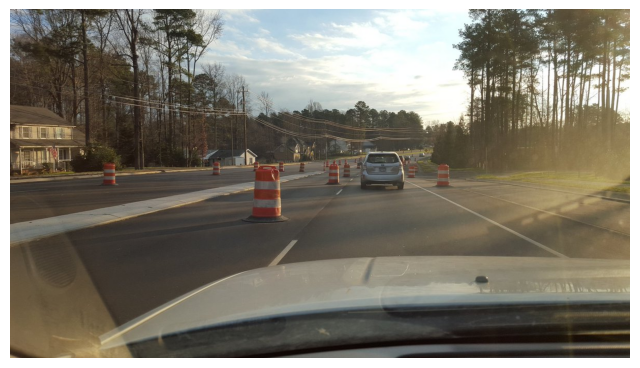

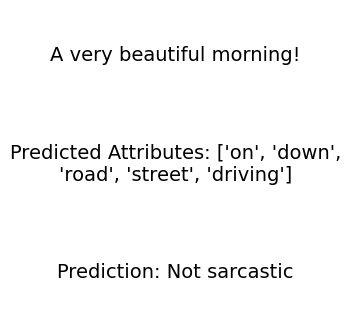

In [159]:
x = ''
if prediction[0][0] >= 0.5127:
    x = 'Sarcasm fs'
else:
    x = 'Not sarcastic'

# Display the image, caption, and prediction
plt.figure(figsize=(8, 8))

image = Image.open(sample_image_path).convert("RGB")
plt.imshow(image)
plt.axis('off')  # Hide axes for better visualization

plt.figure(figsize=(4, 4))
plt.subplot(3, 1, 1)
plt.text(0.5, 0.5, sample_text, fontsize=14, ha='center', va='center', wrap=True)
plt.axis('off')

plt.subplot(3, 1,2)
plt.text(0.5, 0.5,f"Predicted Attributes: {predicted_attributes}", fontsize=14, ha='center', va='center', wrap=True)
plt.axis('off')

# Display prediction
plt.subplot(3, 1, 3)
plt.text(0.5, 0.5, f"Prediction: {x}", fontsize=14, ha='center', va='center', wrap=True)
plt.axis('off')

plt.show()
